# Language Conditioned Robot Skills (LCRS) - Live Demo

In [1]:
from calvin_agent.utils.transforms import ScaleImageTensor
from calvin_agent.utils.utils import print_system_env_info, get_last_checkpoint, format_sftp_path

from torchvision.transforms import Normalize
from pytorch_lightning import Callback, LightningModule, seed_everything, Trainer
from pytorch_lightning.utilities.cloud_io import load as pl_load

from omegaconf import DictConfig, OmegaConf
from hydra.utils import instantiate
from hydra import initialize, compose

from matplotlib import pyplot as plt
from IPython.display import display
from pathlib import Path

from typing import List
from enum import Enum

import lcrs
import sys
import time
import os
import torch
import numpy as np
import threading
import cv2
import ipywidgets as widgets

## Load the pre-trained model

First we load the load the pre-trained lcrs model as well as the language embedding

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Dataset(Enum):
    D = "dataset/task_D_D"
    ABC = "dataset/task_ABC_D"
    ABCD = "dataset/task_ABCD_D"
    debug = "dataset/calvin_debug_dataset"

In [3]:
#==================================================
# SELECT DATASET & MODEL YOU WANT TO USE FOR DEMO HERE
#==================================================
selectedDataset = Dataset.debug
model_checkpoint_path = "~/runs/2024-03-07/21-32-22/saved_models/epoch=0.ckpt"

In [4]:
EMBEDDING_PATH = f"{os.getcwd()}/{selectedDataset.value}/validation/lang_annotations/embeddings.npy"
if not os.path.exists(EMBEDDING_PATH):
    raise Exception("Embedding not found")

with initialize(config_path="./conf"):
    cfg = compose(config_name="config", overrides=[f"datamodule.root_data_dir={selectedDataset.value}"])
    
seed_everything(cfg.seed, workers=True)

datamodule = instantiate(cfg.datamodule, training_repo_root=Path(lcrs.__file__).parents[1])
model = instantiate(cfg.model)
model = model.to(device)
chk = Path(model_checkpoint_path)

if chk:
    #pretrain_chk = pl_load(format_sftp_path(Path(cfg.pretrain_chk)), map_location=lambda storage, loc: storage)
    pretrain_chk = pl_load(format_sftp_path(chk), map_location=lambda storage, loc: storage)
    model.load_state_dict(pretrain_chk["state_dict"], strict=False)
    model.load_lang_embeddings(EMBEDDING_PATH)
    print("Loaded pre-trained model")
else:
    raise(Exception("No pre-trained model found"))

Global seed set to 42
/opt/conda/envs/lcrs_venv/lib/python3.10/site-packages/pytorch_lightning/utilities/cloud_io.py:41: LightningDeprecationWarning: `pytorch_lightning.utilities.cloud_io.load` has been deprecated in v1.8.0 and will be removed in v1.10.0. This function is internal but you can copy over its implementation.
  rank_zero_deprecation(


Loaded pre-trained model


## Setup CALVIN simulation environment
Now we configure and setup a basic CALVIN environment that we can later use to run the simulation on.

In [5]:
# Run this to check if the installation was succesful
from calvin_env.envs.play_table_env import PlayTableSimEnv

pybullet build time: Nov 28 2023 23:45:17


In [6]:
with initialize(config_path="./calvin/calvin_env/conf/"):
  env_cfg = compose(config_name="config_data_collection.yaml", overrides=["cameras=static_and_gripper"])
  env_cfg.env["use_egl"] = False
  env_cfg.env["show_gui"] = False
  env_cfg.env["use_vr"] = False
  env_cfg.env["use_scene_info"] = True
  print(env_cfg.env)

{'_target_': 'calvin_env.envs.play_table_env.PlayTableSimEnv', '_recursive_': False, 'cameras': '${cameras}', 'seed': 0, 'bullet_time_step': 240.0, 'use_vr': False, 'show_gui': False, 'robot_cfg': '${robot}', 'scene_cfg': '${scene}', 'use_scene_info': True, 'use_egl': False, 'control_freq': 30}


/opt/conda/envs/lcrs_venv/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config_data_collection.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/opt/conda/envs/lcrs_venv/lib/python3.10/site-packages/hydra/core/default_element.py:122: UserWarning: In 'vr_input/vr_controller/vive': Usage of deprecated keyword in package header '# @package _group_'.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/changes_to_package_header for more information
  deprecation_warning(


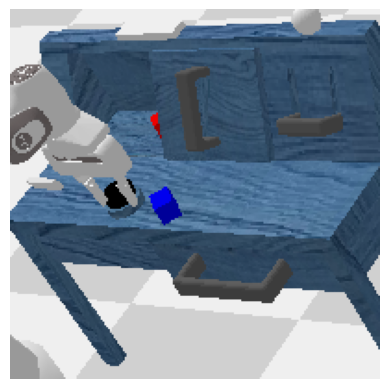

In [7]:
env = instantiate(env_cfg.env)
observation = env.reset()
rgb = env.render(mode="rgb_array")[:,:,::-1]

#Show the image with matplotlib
plt.imshow(rgb)
plt.axis('off')
plt.show()

## Inference


In [8]:
def transformObservation(observation):
    """
    Transforms the environment observation to the required dimension of the model
    """
    # match dimensions of model step
    observation["rgb_obs"]["rgb_static"] = torch.from_numpy(observation["rgb_obs"]["rgb_static"]).unsqueeze(0).unsqueeze(0).permute(0, 1, 4, 2, 3)
    observation["rgb_obs"]["rgb_gripper"] = torch.from_numpy(observation["rgb_obs"]["rgb_gripper"]).unsqueeze(0).unsqueeze(0).permute(0, 1, 4, 2, 3)

    # normalize
    sit = ScaleImageTensor()
    observation["rgb_obs"]["rgb_static"] = sit(observation["rgb_obs"]["rgb_static"])
    observation["rgb_obs"]["rgb_gripper"] = sit(observation["rgb_obs"]["rgb_gripper"])
    normalizer = Normalize([0.5], [0.5], True)
    normalizer(observation["rgb_obs"]["rgb_static"])
    normalizer(observation["rgb_obs"]["rgb_gripper"])

    # same device required --> to cuda
    observation["rgb_obs"]["rgb_static"] = observation["rgb_obs"]["rgb_static"].to(device)
    observation["rgb_obs"]["rgb_gripper"] = observation["rgb_obs"]["rgb_gripper"].to(device)
    return observation

In [9]:
def run_simulation():
    """
    Starts a simulation and shows the resulting images.
    Note that the following variables need to be set:
        - task:str = Instruction in natural language
        - max_seconds = Maximal duration in seconds before the simulation automatically stops
    Also note, that the images are printed with matplotlib to be able to display them in a jupyter-environment without a display.
    In order to see a gif-version, you need to use cv2.imshow() instead (see commented line)
    """
    observation = env.reset()
    endtime = time.time() + max_seconds
    while time.time() < endtime and not stop_execution:
        observation = transformObservation(observation)
        action = model.step(observation, task)
        action = action[0][0]
        action = action.detach().to('cpu').numpy()
        observation, reward, done, info = env.step(action)
        rgb = env.render(mode="rgb_array")[:,:,::-1]
    
        # Show the image with matplotlib
        #cv2.imshow(rgb) # does not work on cluster notebook
        plt.imshow(rgb)
        plt.axis('off')
        plt.show()
    
        # Reset the model & the environment
        model.reset()
    print("Simulation stopped")

In [10]:
# Setup widget for manual simulation termination
button = widgets.Button(description="Stop simulation") 
output = widgets.Output()

def on_button_clicked(event):
    global stop_execution
    stop_execution = True
    
button.on_click(on_button_clicked)

Button(description='Stop simulation', style=ButtonStyle())

Output()

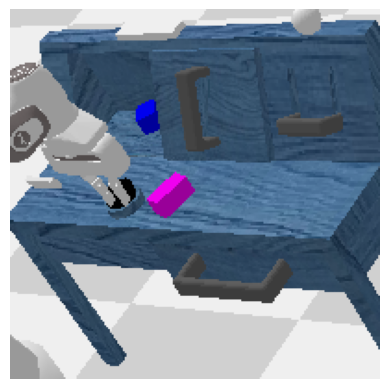

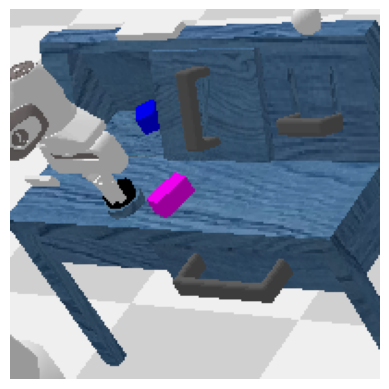

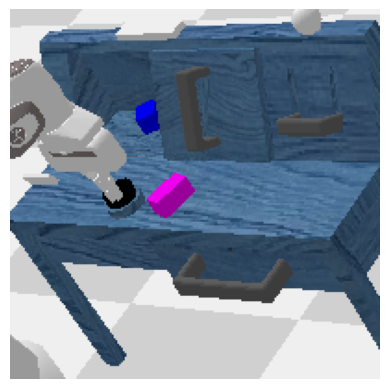

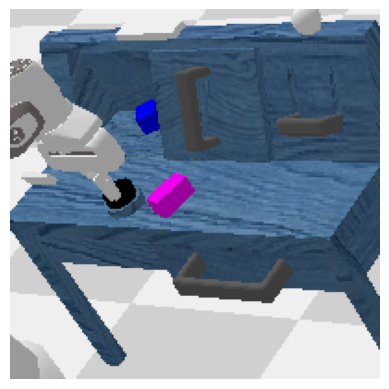

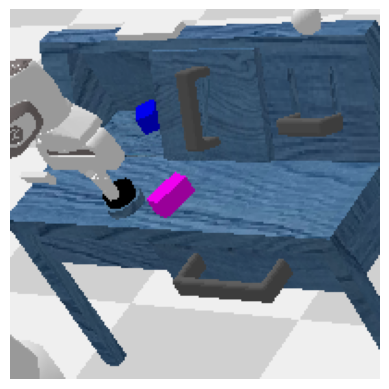

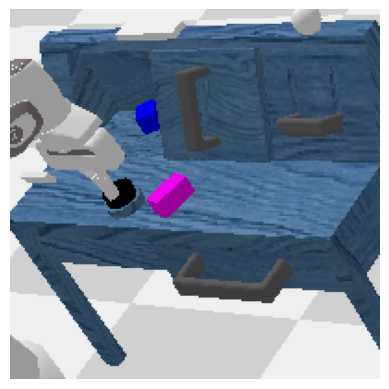

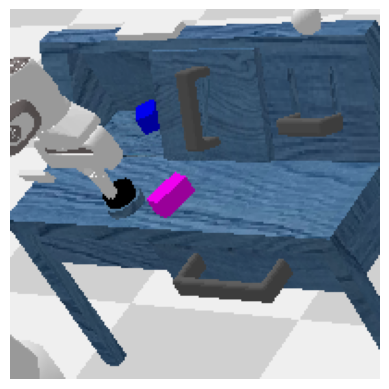

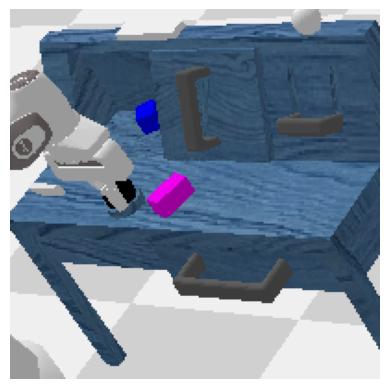

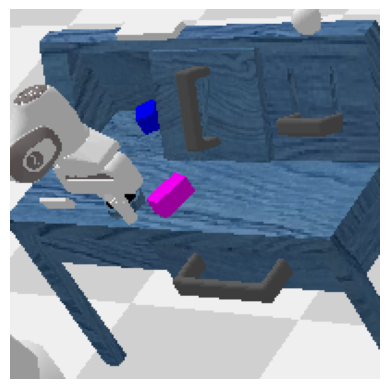

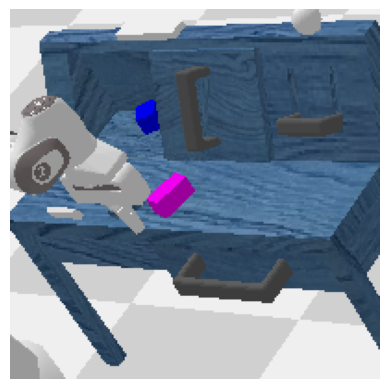

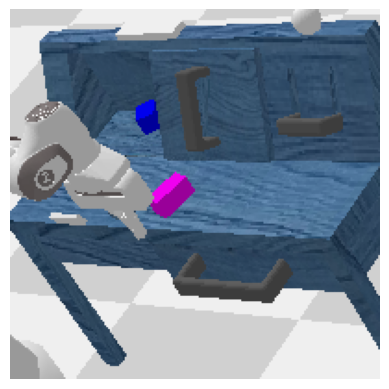

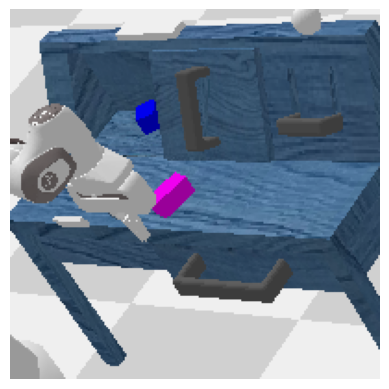

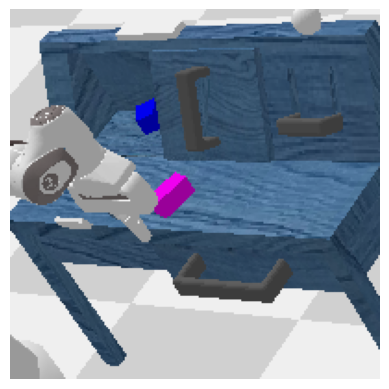

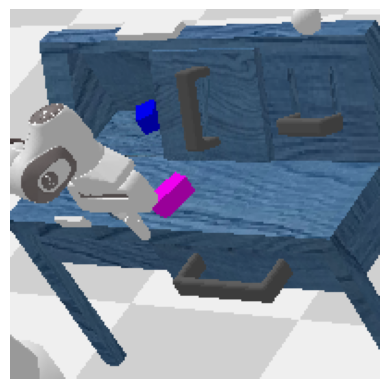

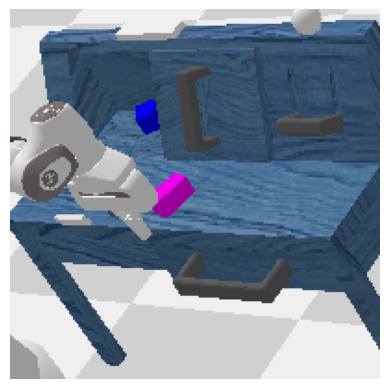

Simulation stopped


In [15]:
# ==============================
# Configure simulation run
# ==============================
task="push the handle to close the drawer"
max_seconds = 10
#===============================
display(button, output)
stop_execution = False
threading.Thread(target=run_simulation).start()